# Information Retrieval Coursework (7071CEM)

Task:
Whether as a separate program or integrated with search engine, a subject classification functionality is needed.

This program implements a text classifier using a NLP techniques and a selection of classification algorithms.

Based on the datasets sourced, the three chosen classifications are:

* Business
* health
* sports

## Imports

In [34]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp

# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


# Load Datasets

In [35]:
text_df = pd.DataFrame(columns=['Text','Class'])
text_df.head()

,Text,Class


In [36]:
# Function to read the text files into one dataframe
def readfiles_to_dataframe(directory, category):
    arr = os.listdir(directory)
    strtext = ".txt"
    for textfile in arr:
        if textfile.__contains__(strtext):
            fileObject = open(directory + textfile, "r")
            data = fileObject.read()
            ouvert = pd.read_csv('news.csv', index_col="Unnamed: 0")
            ouvert = ouvert.append({"Class": str(category), "Text": data},ignore_index=True)
            ouvert.to_csv('news.csv')   


In [37]:
full_df = pd.read_csv('news.csv')
print(full_df.shape)
full_df.head()

(186, 3)


,Unnamed: 0,Text,Class
0,0,Roger Federer Advances to Semifinals in Wimble...,sports
1,1,Lewis Hamilton Secures Pole Position for Briti...,sports
2,2,Simone Biles Clinches Gold in Women's Gymnasti...,sports
3,3,Rafael Nadal Triumphs in Epic Five-Set Battle ...,sports
4,4,Serena Williams Makes a Resounding Comeback in...,sports


In [38]:
full_df.drop(columns=['Unnamed: 0'], inplace=True)
full_df.head()

,Text,Class
0,Roger Federer Advances to Semifinals in Wimble...,sports
1,Lewis Hamilton Secures Pole Position for Briti...,sports
2,Simone Biles Clinches Gold in Women's Gymnasti...,sports
3,Rafael Nadal Triumphs in Epic Five-Set Battle ...,sports
4,Serena Williams Makes a Resounding Comeback in...,sports


## 1. Dataset Exploration

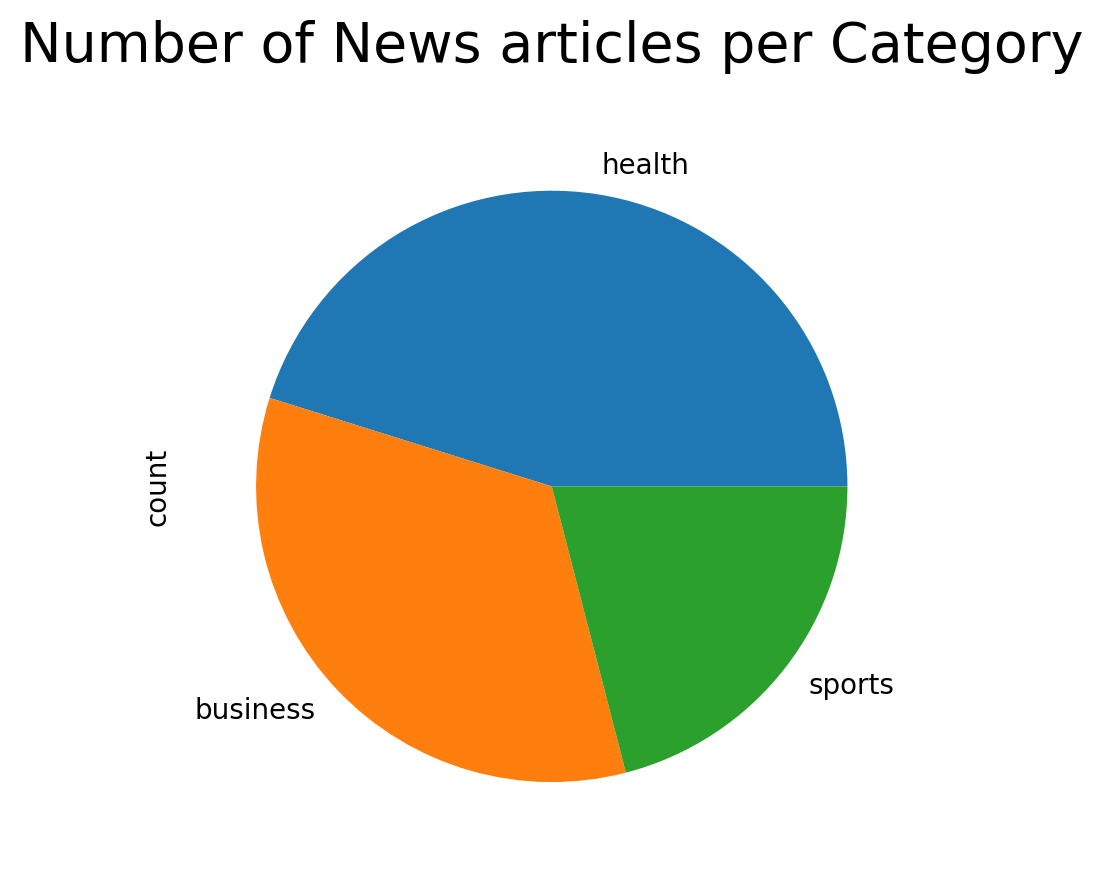

In [39]:
full_df['Class'].value_counts().plot(kind='pie')
plt.title('Number of News articles per Category', size=20, pad=20);

In [40]:
# Check for missing values
full_df.isna().sum()

Text     0
Class    0
dtype: int64

## 2. Text Preprocessing

Here, unwanted parts of the text are removed such as special characters. 

In [41]:
def preprocess(df):
    # Remove special characters
    df['Text2'] = df['Text'].replace('\n',' ')
    df['Text2'] = df['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['Text2'] = df['Text2'].str.lower()
    df['Text2'] = df['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['Text2'] = df['Text2'].apply(lematize)

In [42]:
preprocess(full_df)

### Demonstration of Preprocessing

**Original:**

In [43]:
full_df.iloc[1]['Text']

"Lewis Hamilton Secures Pole Position for British Grand Prix Mercedes-AMG Petronas Formula One driver Lewis Hamilton showcased his unrivaled speed and determination by clinching pole position for the British Grand Prix. The seven-time World Champion unleashed his skillful driving abilities, navigating the iconic Silverstone circuit with remarkable precision. Hamilton's pole position achievement not only demonstrates his exceptional talent but also positions him favorably for the race, leaving his competitors with a tough challenge ahead."

**Processed:**

In [44]:
full_df.iloc[1]['Text2']

'lewis hamilton secures pole position british grand prix mercedesamg petronas formula one driver lewis hamilton showcased unrivaled speed determination clinch pole position british grand prix seventime world champion unleashed skillful drive ability navigate iconic silverstone circuit remarkable precision hamilton pole position achievement demonstrates exceptional talent also position favorably race leave competitor tough challenge ahead '

## 3. Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(full_df['Text2'], 
                                                    full_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)

#### Check for acceptable category balance

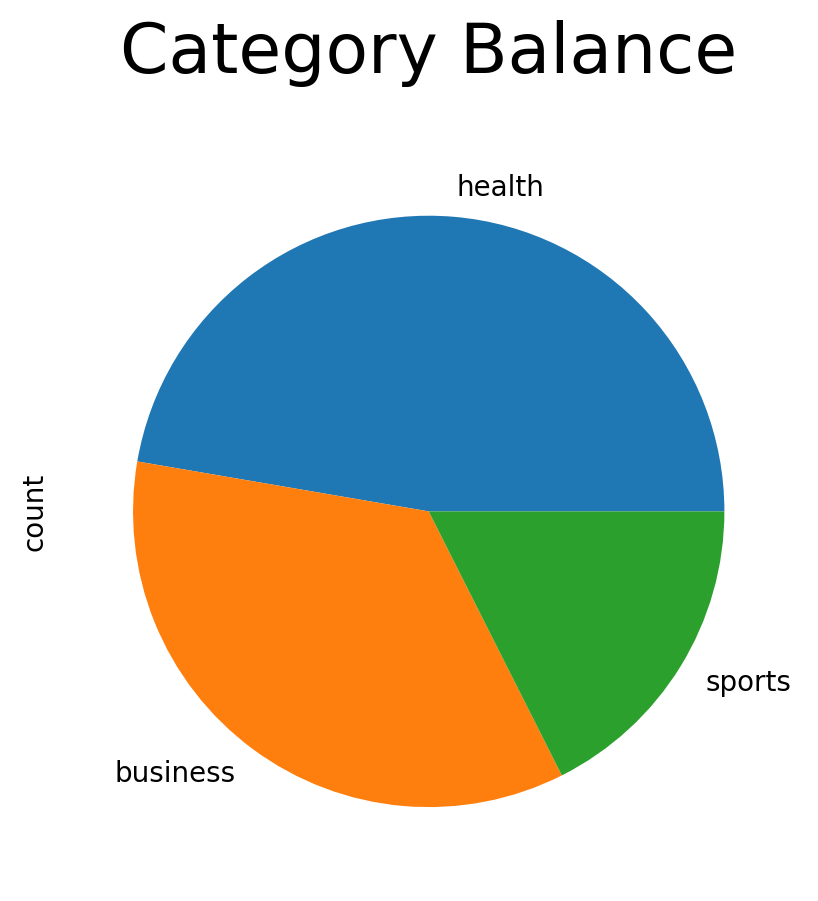

In [46]:
y_train.value_counts().plot(kind='pie')
plt.title('Category Balance', size=25, pad=25);

In [47]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(148,) (38,) (148,) (38,)


## 4.  Vectorize

In [48]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

## 5.  Construct Model

In [49]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [50]:
dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [51]:
l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [52]:
dectree

{'fit_time': array([0.0282805 , 0.0299809 , 0.02366352]),
 'score_time': array([0.01100588, 0.00900173, 0.00983858]),
 'test_accuracy': array([0.98      , 1.        , 0.91836735]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.98030409, 1.        , 0.92537621]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.982     , 1.        , 0.94805195]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.98      , 1.        , 0.91836735]),
 'train_recall_weighted': array([1., 1., 1.])}

In [53]:
ridge

{'fit_time': array([0.02501106, 0.0258882 , 0.02095556]),
 'score_time': array([0.00930905, 0.00789928, 0.00992751]),
 'test_accuracy': array([1., 1., 1.]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([1., 1., 1.]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([1., 1., 1.]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([1., 1., 1.]),
 'train_recall_weighted': array([1., 1., 1.])}

In [54]:
bayes

{'fit_time': array([0.01981497, 0.02189517, 0.01861787]),
 'score_time': array([0.00888777, 0.0088954 , 0.00999117]),
 'test_accuracy': array([0.98      , 0.97959184, 1.        ]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.97962453, 0.97949844, 1.        ]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.98083333, 0.98129252, 1.        ]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.98      , 0.97959184, 1.        ]),
 'train_recall_weighted': array([1., 1., 1.])}

In [55]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

#### Decision Tree metrics

In [56]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.980000,0.982000,0.980000,0.980304
1,1.000000,1.000000,1.000000,1.000000
2,0.918367,0.948052,0.918367,0.925376


#### Multinomial Naive Bayes metrics

In [57]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.980000,0.980833,0.980000,0.979625
1,0.979592,0.981293,0.979592,0.979498
2,1.000000,1.000000,1.000000,1.000000


#### Ridge Classifier metrics

In [58]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0


#### Average metrics

In [59]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')

Decision Tree Mean Metrics:
test_accuracy              0.966122
test_precision_weighted    0.976684
test_recall_weighted       0.966122
test_f1_weighted           0.968560
dtype: float64
  
Naive Bayes Mean Metrics:
test_accuracy              0.986531
test_precision_weighted    0.987375
test_recall_weighted       0.986531
test_f1_weighted           0.986374
dtype: float64
  
Ridge Classifier Mean Metrics:
test_accuracy              1.0
test_precision_weighted    1.0
test_recall_weighted       1.0
test_f1_weighted           1.0
dtype: float64
  


### Selection of Model
From the metrics obtained above, we see that **Ridge Classifier** performs best. However, the **Multinomial Naive Bayes classifier** is chosen to create the final model.

This is because it **has the ability to provide probability score** for each prediction it makes, while scoring similarly to the best model.

In [60]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [61]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [62]:
# Create model
CLASSYfier = create_and_fit(MultinomialNB(), X, y)

In [63]:
CLASSYfier.classes_

array(['business', 'health', 'sports'], dtype='<U8')

## FINAL TESTING:



In [64]:
input_text = '(Reuters) -Netflix Inc said it would make a deeper dive into video games as the movie and TV streaming service projected weak subscriber growth amid growing competition and the lifting of pandemic restrictions that had kept people at home.'
CLASSYfier.predict_proba([input_text])

array([[0.64865503, 0.19072955, 0.16061542]])

In [65]:
CLASSYfier.predict([input_text])[0]

'business'

Interestingly, since the streaming services are also businesses, the model reflects this with a `0.39` probability for the business category.

## GUI

In [66]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText

window = tk.Tk()
window.configure(bg='#98AFC7') 
window.title("IR SUBJECT CLASSIFIER")
window.minsize(600,400)
text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    BUSINESS = round(pr[0][0], 3)
    HEALTH = round(pr[0][1], 3)
    SPORTS = round(pr[0][2], 3)
    
    lines = [f"Business: {BUSINESS}" , f"Health: {HEALTH}", f"Sports: {SPORTS}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    
def classify_text(input_text):
    out = CLASSYfier.predict([input_text])[0]
    probs = CLASSYfier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Please enter the text", bg="#87CEFA",font=("Cambria", 15))
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify",font=("Cambria", 12), bg="#87CEFA", command=clickMe)
btn.grid(column=0, row=2)
   
window.mainloop()